In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib as mpl
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from astropy.convolution.kernels import CustomKernel

from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

In [2]:
%matplotlib inline

In [3]:
plt.style.use('court.mplstyle')

try Monotone interpolants https://docs.scipy.org/doc/scipy/tutorial/interpolate/1D.html

In [4]:
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator

In [5]:
# https://dsp.stackexchange.com/questions/1676/savitzky-golay-smoothing-filter-for-not-equally-spaced-data

def non_uniform_savgol(x, y, window, polynom):
    """
    Applies a Savitzky-Golay filter to y with non-uniform spacing
    as defined in x

    This is based on https://dsp.stackexchange.com/questions/1676/savitzky-golay-smoothing-filter-for-not-equally-spaced-data
    The borders are interpolated like scipy.signal.savgol_filter would do

    Parameters
    ----------
    x : array_like
        List of floats representing the x values of the data
    y : array_like
        List of floats representing the y values. Must have same length
        as x
    window : int (odd)
        Window length of datapoints. Must be odd and smaller than x
    polynom : int
        The order of polynom used. Must be smaller than the window size

    Returns
    -------
    np.array of float
        The smoothed y values
    """
    if len(x) != len(y):
        raise ValueError('"x" and "y" must be of the same size')

    if len(x) < window:
        raise ValueError('The data size must be larger than the window size')

    if type(window) is not int:
        raise TypeError('"window" must be an integer')

    if window % 2 == 0:
        raise ValueError('The "window" must be an odd integer')

    if type(polynom) is not int:
        raise TypeError('"polynom" must be an integer')

    if polynom >= window:
        raise ValueError('"polynom" must be less than "window"')

    half_window = window // 2
    polynom += 1

    # Initialize variables
    A = np.empty((window, polynom))     # Matrix
    tA = np.empty((polynom, window))    # Transposed matrix
    t = np.empty(window)                # Local x variables
    y_smoothed = np.full(len(y), np.nan)

    # Start smoothing
    for i in range(half_window, len(x) - half_window, 1):
        # Center a window of x values on x[i]
        for j in range(0, window, 1):
            t[j] = x[i + j - half_window] - x[i]

        # Create the initial matrix A and its transposed form tA
        for j in range(0, window, 1):
            r = 1.0
            for k in range(0, polynom, 1):
                A[j, k] = r
                tA[k, j] = r
                r *= t[j]

        # Multiply the two matrices
        tAA = np.matmul(tA, A)

        # Invert the product of the matrices
        tAA = np.linalg.inv(tAA)

        # Calculate the pseudoinverse of the design matrix
        coeffs = np.matmul(tAA, tA)

        # Calculate c0 which is also the y value for y[i]
        y_smoothed[i] = 0
        for j in range(0, window, 1):
            y_smoothed[i] += coeffs[0, j] * y[i + j - half_window]

        # If at the end or beginning, store all coefficients for the polynom
        if i == half_window:
            first_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    first_coeffs[k] += coeffs[k, j] * y[j]
        elif i == len(x) - half_window - 1:
            last_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    last_coeffs[k] += coeffs[k, j] * y[len(y) - window + j]

    # Interpolate the result at the left border
    for i in range(0, half_window, 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += first_coeffs[j] * x_i
            x_i *= x[i] - x[half_window]

    # Interpolate the result at the right border
    for i in range(len(x) - half_window, len(x), 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += last_coeffs[j] * x_i
            x_i *= x[i] - x[-half_window - 1]

    return y_smoothed

In [6]:
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_WISEJ194218.38-203247.5_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_AOHer_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-14_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-16_ATLAS.csv')
atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-19_ATLAS.csv')
atlas

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57230.363301,12.044,0.002,55268.0,100.0,o,0,142.75,285.39033,14.93599,5243.16,529.14,3.79,3.60,-20.8,-0.510,18.66,19.83,02a57230o0153o
1,57230.364071,12.001,0.002,57498.0,98.0,o,0,144.51,285.39033,14.93599,7367.53,10265.03,3.88,3.63,-77.6,-0.471,18.70,19.91,02a57230o0154o
2,57230.392834,12.014,0.002,56832.0,99.0,o,0,214.81,285.39033,14.93599,3442.31,124.97,3.97,3.51,-26.0,-0.508,18.76,19.99,02a57230o0188o
3,57230.395061,12.054,0.002,54762.0,97.0,o,0,107.76,285.39033,14.93599,5564.60,9856.66,3.68,3.55,-62.0,-0.468,18.73,19.93,02a57230o0190o
4,57230.415453,12.005,0.002,57286.0,98.0,o,0,152.72,285.39033,14.93599,1974.56,1598.85,3.92,3.53,-45.6,-0.478,18.77,19.98,02a57230o0213o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3058,60108.305950,17.976,0.059,234.0,14.0,o,0,2.49,285.39033,14.93599,3020.85,4432.94,1.94,1.77,74.8,-0.431,18.96,20.52,04a60108o0784o
3059,60108.310971,18.019,0.085,225.0,19.0,o,0,0.98,285.39033,14.93599,2966.31,4351.88,1.93,1.75,71.8,-0.428,18.95,20.46,04a60108o0795o
3060,60108.325752,17.942,0.079,242.0,19.0,o,0,1.02,285.39033,14.93599,2955.37,4458.28,1.98,1.80,70.9,-0.421,18.88,20.32,04a60108o0827o
3061,60109.451577,18.911,0.522,99.0,52.0,c,0,1.21,285.39033,14.93599,2974.43,4421.28,3.03,2.91,35.9,-0.415,17.78,19.41,02a60109o0267c


In [7]:
oband = atlas[atlas['f']=='o']
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57230.363301,12.044,0.002,55268.0,100.0,o,0,142.75,285.39033,14.93599,5243.16,529.14,3.79,3.60,-20.8,-0.510,18.66,19.83,02a57230o0153o
1,57230.364071,12.001,0.002,57498.0,98.0,o,0,144.51,285.39033,14.93599,7367.53,10265.03,3.88,3.63,-77.6,-0.471,18.70,19.91,02a57230o0154o
2,57230.392834,12.014,0.002,56832.0,99.0,o,0,214.81,285.39033,14.93599,3442.31,124.97,3.97,3.51,-26.0,-0.508,18.76,19.99,02a57230o0188o
3,57230.395061,12.054,0.002,54762.0,97.0,o,0,107.76,285.39033,14.93599,5564.60,9856.66,3.68,3.55,-62.0,-0.468,18.73,19.93,02a57230o0190o
4,57230.415453,12.005,0.002,57286.0,98.0,o,0,152.72,285.39033,14.93599,1974.56,1598.85,3.92,3.53,-45.6,-0.478,18.77,19.98,02a57230o0213o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3056,60103.508484,17.797,0.074,276.0,20.0,o,0,0.98,285.39033,14.93599,8706.61,698.96,2.12,1.61,-63.1,-0.546,18.96,19.99,02a60103o0551o
3057,60108.303209,17.852,0.079,263.0,21.0,o,0,0.98,285.39033,14.93599,2999.14,4396.12,2.02,1.81,76.0,-0.430,18.97,20.53,04a60108o0778o
3058,60108.305950,17.976,0.059,234.0,14.0,o,0,2.49,285.39033,14.93599,3020.85,4432.94,1.94,1.77,74.8,-0.431,18.96,20.52,04a60108o0784o
3059,60108.310971,18.019,0.085,225.0,19.0,o,0,0.98,285.39033,14.93599,2966.31,4351.88,1.93,1.75,71.8,-0.428,18.95,20.46,04a60108o0795o


In [8]:
oband = oband.sort_values(by=['mjd'],axis=0,ascending=True,ignore_index=True)
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57230.363301,12.044,0.002,55268.0,100.0,o,0,142.75,285.39033,14.93599,5243.16,529.14,3.79,3.60,-20.8,-0.510,18.66,19.83,02a57230o0153o
1,57230.364071,12.001,0.002,57498.0,98.0,o,0,144.51,285.39033,14.93599,7367.53,10265.03,3.88,3.63,-77.6,-0.471,18.70,19.91,02a57230o0154o
2,57230.392834,12.014,0.002,56832.0,99.0,o,0,214.81,285.39033,14.93599,3442.31,124.97,3.97,3.51,-26.0,-0.508,18.76,19.99,02a57230o0188o
3,57230.395061,12.054,0.002,54762.0,97.0,o,0,107.76,285.39033,14.93599,5564.60,9856.66,3.68,3.55,-62.0,-0.468,18.73,19.93,02a57230o0190o
4,57230.415453,12.005,0.002,57286.0,98.0,o,0,152.72,285.39033,14.93599,1974.56,1598.85,3.92,3.53,-45.6,-0.478,18.77,19.98,02a57230o0213o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2370,60103.508484,17.797,0.074,276.0,20.0,o,0,0.98,285.39033,14.93599,8706.61,698.96,2.12,1.61,-63.1,-0.546,18.96,19.99,02a60103o0551o
2371,60108.303209,17.852,0.079,263.0,21.0,o,0,0.98,285.39033,14.93599,2999.14,4396.12,2.02,1.81,76.0,-0.430,18.97,20.53,04a60108o0778o
2372,60108.305950,17.976,0.059,234.0,14.0,o,0,2.49,285.39033,14.93599,3020.85,4432.94,1.94,1.77,74.8,-0.431,18.96,20.52,04a60108o0784o
2373,60108.310971,18.019,0.085,225.0,19.0,o,0,0.98,285.39033,14.93599,2966.31,4351.88,1.93,1.75,71.8,-0.428,18.95,20.46,04a60108o0795o


In [9]:
oband = oband.drop_duplicates(subset=['mjd'],ignore_index=True) 
    # this keeps the first entry, I'd love if it took an average
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57230.363301,12.044,0.002,55268.0,100.0,o,0,142.75,285.39033,14.93599,5243.16,529.14,3.79,3.60,-20.8,-0.510,18.66,19.83,02a57230o0153o
1,57230.364071,12.001,0.002,57498.0,98.0,o,0,144.51,285.39033,14.93599,7367.53,10265.03,3.88,3.63,-77.6,-0.471,18.70,19.91,02a57230o0154o
2,57230.392834,12.014,0.002,56832.0,99.0,o,0,214.81,285.39033,14.93599,3442.31,124.97,3.97,3.51,-26.0,-0.508,18.76,19.99,02a57230o0188o
3,57230.395061,12.054,0.002,54762.0,97.0,o,0,107.76,285.39033,14.93599,5564.60,9856.66,3.68,3.55,-62.0,-0.468,18.73,19.93,02a57230o0190o
4,57230.415453,12.005,0.002,57286.0,98.0,o,0,152.72,285.39033,14.93599,1974.56,1598.85,3.92,3.53,-45.6,-0.478,18.77,19.98,02a57230o0213o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2370,60103.508484,17.797,0.074,276.0,20.0,o,0,0.98,285.39033,14.93599,8706.61,698.96,2.12,1.61,-63.1,-0.546,18.96,19.99,02a60103o0551o
2371,60108.303209,17.852,0.079,263.0,21.0,o,0,0.98,285.39033,14.93599,2999.14,4396.12,2.02,1.81,76.0,-0.430,18.97,20.53,04a60108o0778o
2372,60108.305950,17.976,0.059,234.0,14.0,o,0,2.49,285.39033,14.93599,3020.85,4432.94,1.94,1.77,74.8,-0.431,18.96,20.52,04a60108o0784o
2373,60108.310971,18.019,0.085,225.0,19.0,o,0,0.98,285.39033,14.93599,2966.31,4351.88,1.93,1.75,71.8,-0.428,18.95,20.46,04a60108o0795o


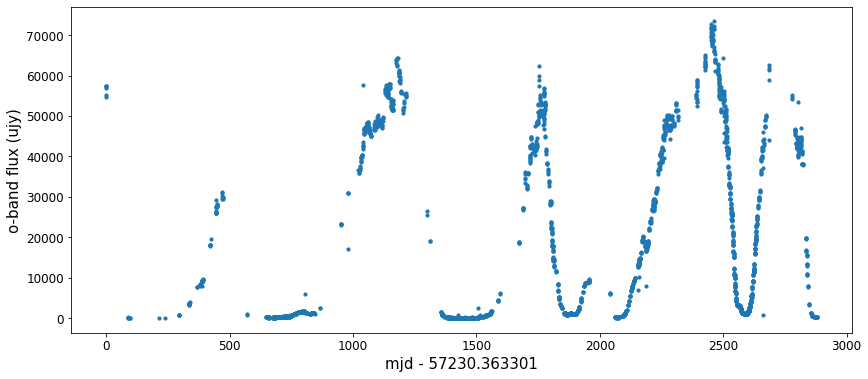

In [10]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['ujy'],s=10)#/(80000),s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band flux (ujy)')
# plt.ylim(-100,1000)
# plt.ylim(0.6,1.2)
# plt.xlim(1000,2000)
plt.show()

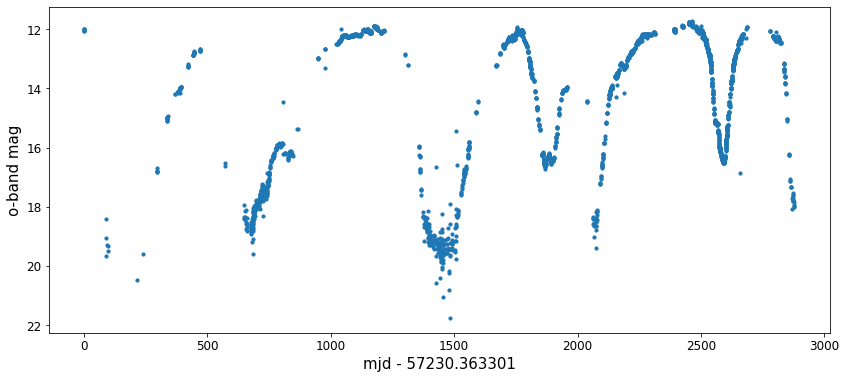

In [11]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10)#/(80000),s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band mag')
# plt.ylim(top=1.2)
# plt.ylim(0.6,1.2)
# plt.xlim(1000,2000)
plt.show()

In [12]:
# median_filtered = sp.signal.medfilt(oband['m'],kernel_size=5)

In [13]:
# plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd']-oband['mjd'][0],median_filtered,s=10)
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('median filtered o-band magnitude')
# plt.show()

In [14]:
savgol_filtered = non_uniform_savgol(np.asarray(oband['mjd']-oband['mjd'][0]),
                                     np.asarray(oband['m']),
                                   window=7, polynom=1)

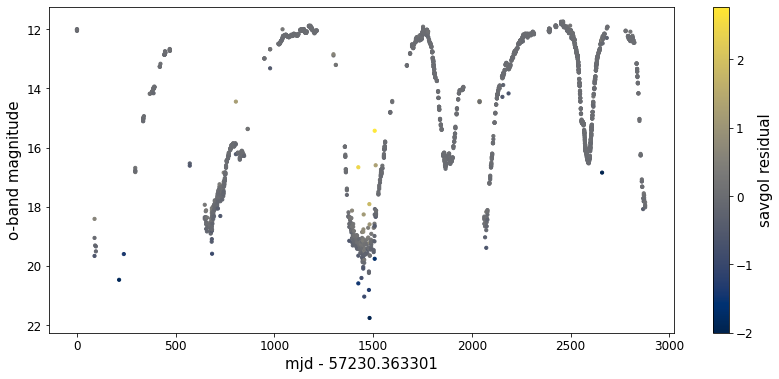

In [15]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10,
            c=savgol_filtered-oband['m'],cmap='cividis')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band magnitude')
plt.colorbar(label='savgol residual')
# plt.clim(vmax=-1)
plt.clim(vmin=-2)
plt.show()

0.18472528838738997


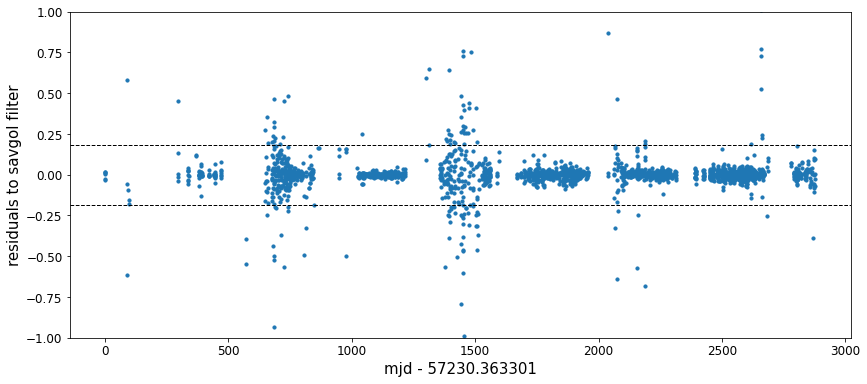

In [16]:
deviation = np.std(savgol_filtered-oband['m'])
print(deviation)

plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],savgol_filtered-oband['m'],s=10)
plt.axhline(deviation,color='k',linestyle='--')
plt.axhline(-deviation,color='k',linestyle='--')
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('residuals to savgol filter')
plt.ylim(-1,1)
plt.show()

In [17]:
# plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10,
#             c=median_filtered-oband['m'],cmap='cividis')
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('o-band magnitude')
# plt.colorbar(label='median residual')
# # plt.clim(vmax=-1)
# plt.clim(vmin=-2)
# plt.show()

In [18]:
# deviation = np.std((median_filtered-oband['m']))
# print(deviation)

# plt.figure(figsize=(14,6))
# # plt.axvline(oband['mjd'][1000]-oband['mjd'][0])
# plt.scatter(oband['mjd']-oband['mjd'][0],median_filtered-oband['m'],s=10)
# plt.axhline(deviation,color='k',linestyle='--')
# plt.axhline(-deviation,color='k',linestyle='--')
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('residuals to median filter')
# plt.ylim(-1,1)
# plt.show()

In [19]:
mask = np.where(np.abs(savgol_filtered-oband['m'])<deviation,True,False)
mask

# mask = np.where(np.abs(median_filtered-oband['m'])<0.25,True,False)
# mask

array([ True,  True,  True, ...,  True,  True,  True])

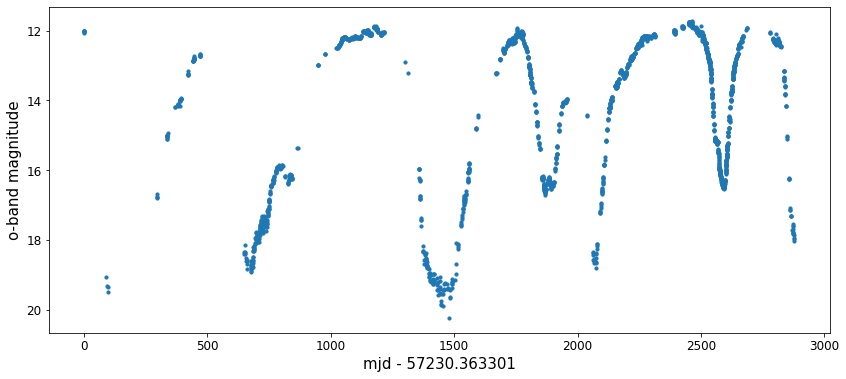

In [20]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd'][mask]-oband['mjd'][0],oband['m'][mask],s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band magnitude')
plt.show()

In [21]:
# median_filtered_oband = oband.iloc[mask]
# median_filtered_oband.reset_index(drop=True,inplace=True)
# median_filtered_oband

savgol_filtered_oband = oband.iloc[mask]
savgol_filtered_oband.reset_index(drop=True,inplace=True)
savgol_filtered_oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57230.363301,12.044,0.002,55268.0,100.0,o,0,142.75,285.39033,14.93599,5243.16,529.14,3.79,3.60,-20.8,-0.510,18.66,19.83,02a57230o0153o
1,57230.364071,12.001,0.002,57498.0,98.0,o,0,144.51,285.39033,14.93599,7367.53,10265.03,3.88,3.63,-77.6,-0.471,18.70,19.91,02a57230o0154o
2,57230.392834,12.014,0.002,56832.0,99.0,o,0,214.81,285.39033,14.93599,3442.31,124.97,3.97,3.51,-26.0,-0.508,18.76,19.99,02a57230o0188o
3,57230.395061,12.054,0.002,54762.0,97.0,o,0,107.76,285.39033,14.93599,5564.60,9856.66,3.68,3.55,-62.0,-0.468,18.73,19.93,02a57230o0190o
4,57230.415453,12.005,0.002,57286.0,98.0,o,0,152.72,285.39033,14.93599,1974.56,1598.85,3.92,3.53,-45.6,-0.478,18.77,19.98,02a57230o0213o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,60103.508484,17.797,0.074,276.0,20.0,o,0,0.98,285.39033,14.93599,8706.61,698.96,2.12,1.61,-63.1,-0.546,18.96,19.99,02a60103o0551o
2233,60108.303209,17.852,0.079,263.0,21.0,o,0,0.98,285.39033,14.93599,2999.14,4396.12,2.02,1.81,76.0,-0.430,18.97,20.53,04a60108o0778o
2234,60108.305950,17.976,0.059,234.0,14.0,o,0,2.49,285.39033,14.93599,3020.85,4432.94,1.94,1.77,74.8,-0.431,18.96,20.52,04a60108o0784o
2235,60108.310971,18.019,0.085,225.0,19.0,o,0,0.98,285.39033,14.93599,2966.31,4351.88,1.93,1.75,71.8,-0.428,18.95,20.46,04a60108o0795o


In [22]:
iter_savgol_filtered = non_uniform_savgol(np.asarray(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0]),
                                     np.asarray(savgol_filtered_oband['m']),
                                   window=31, polynom=1)

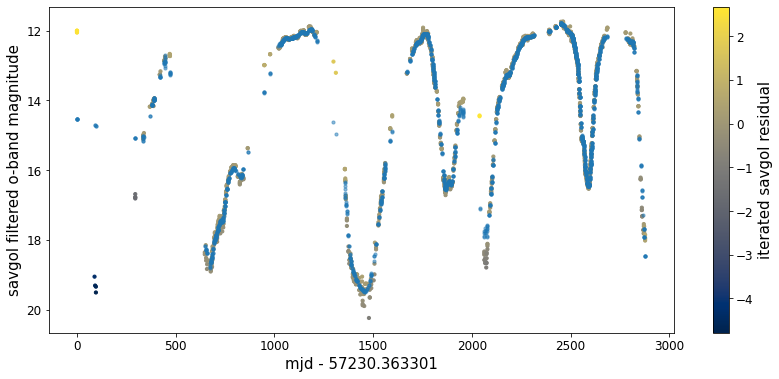

In [23]:
plt.figure(figsize=(14,6))
plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],savgol_filtered_oband['m'],s=10,
            c=iter_savgol_filtered-savgol_filtered_oband['m'],cmap='cividis')
plt.colorbar(label='iterated savgol residual')
plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],iter_savgol_filtered,s=10,alpha=0.5)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='iterated savgol residual')
# plt.clim(vmax=-1)
# plt.clim(vmin=-2)
plt.show()

In [24]:
# local_std/2

In [25]:
# I think we can use that ATLAS saturates at around 11 mag # r ~ 12.5
# and limiting mag is ~20
local_std = np.std((iter_savgol_filtered-savgol_filtered_oband['m']))
saturation_mask = []
halfwidth=5
for i in range(0,len(iter_savgol_filtered)):
    if i > len(iter_savgol_filtered)-halfwidth:
        saturation_mask.append(True)
    elif i < halfwidth:
        saturation_mask.append(True)
    else:
        variation_window = np.max(np.abs(iter_savgol_filtered[i-halfwidth:i+halfwidth]-savgol_filtered_oband['m'][i-halfwidth:i+halfwidth]))
        if variation_window > 0.1 and np.mean(savgol_filtered_oband['m'][i-halfwidth:i+halfwidth])<12:
    #         print('mask me')
            saturation_mask.append(False)
        else:
            saturation_mask.append(True)
# saturation_mask = np.where(np.abs(iter_savgol_filtered-savgol_filtered_oband['m'])<0.25,True,False)
# saturation_mask

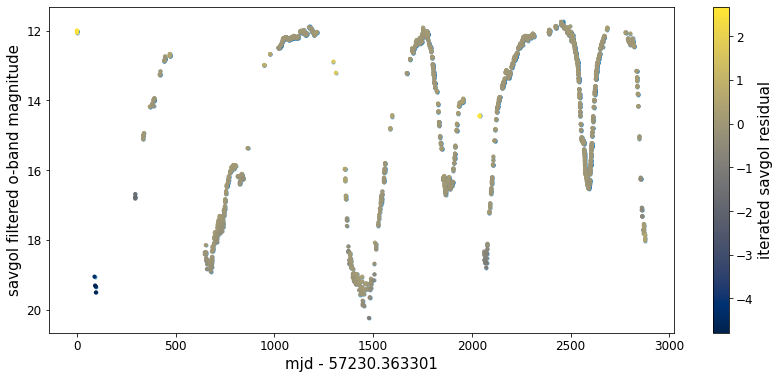

In [26]:
# saturation_replace = np.full(len(saturation_mask),11)

plt.figure(figsize=(14,6))
plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],savgol_filtered_oband['m'],s=10,alpha=0.5)
plt.scatter(savgol_filtered_oband['mjd'][saturation_mask]-savgol_filtered_oband['mjd'][0],savgol_filtered_oband['m'][saturation_mask],s=10,
            c=iter_savgol_filtered[saturation_mask]-savgol_filtered_oband['m'][saturation_mask],cmap='cividis')
# plt.scatter(savgol_filtered_oband['mjd'][np.invert(saturation_mask)]-savgol_filtered_oband['mjd'][0],
#            saturation_replace[np.invert(saturation_mask)],color='darkgrey')
plt.colorbar(label='iterated savgol residual')
# plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],iter_savgol_filtered,s=10,alpha=0.5)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='iterated savgol residual')
# plt.clim(vmax=-1)
# plt.clim(vmin=-2)
plt.show()

In [27]:
# deviation = np.std(iter_savgol_filtered-savgol_filtered_oband['m'])
# print(deviation)

# plt.figure(figsize=(14,6))
# plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],
#             iter_savgol_filtered-savgol_filtered_oband['m'],s=10)
# plt.axhline(deviation,color='k',linestyle='--')
# plt.axhline(-deviation,color='k',linestyle='--')
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('residuals to savgol filter')
# # plt.ylim(-1,1)
# plt.show()

In [28]:
mjd_scale = savgol_filtered_oband['mjd'][0]

# # median_filtered_oband['mjd']-mjd_scale,savgol_filtered
# time = savgol_filtered_oband['mjd']-mjd_scale

# # stddev_arr = []
# # saturation_mask = [False,False,False,False,False]
# deviation = np.std(iter_savgol_filtered-savgol_filtered_oband['m'])
# # print(deviation)

# ### find the gaps in the data
# time_diff = np.diff(time)
# time_diff = np.append(time_diff,0)

# gap_mask = []#[False,False]
# for i in range(0,len(time)):
#     if time_diff[i] > 50:
#         gap_mask.append(True)
# #     elif (gap_mask[i-1] == True and gap_mask[i-2] == False):
# #         gap_mask.append(True)
#     else:
#         gap_mask.append(False)
        
# noise_mask = np.full(len(time),False)
# for i in range(0,len(time[gap_mask])):
#     if i == 0:
#         window = time<=time[time[gap_mask].index[i]]
# #         print(window)
#     elif i == len(time[gap_mask])-1:
#         window = time>=time[time[gap_mask].index[i]]
# #         print(window)
#     else:
#         window = np.logical_and(time>=time[time[gap_mask].index[i]],time<=time[time[gap_mask].index[i+1]])
# #     print(np.std(iter_savgol_filtered[window]-np.asarray(savgol_filtered_oband['m'])[window]))
# #     print(np.mean(np.asarray(savgol_filtered_oband['m'])[window])-np.min(savgol_filtered_oband['m']))
# #     print(np.max(np.asarray(savgol_filtered_oband['m'])[window])-np.min(savgol_filtered_oband['m']))
#     if (np.std(iter_savgol_filtered[window]-np.asarray(savgol_filtered_oband['m'])[window]) > deviation 
#         and len(savgol_filtered_oband['m'][window]) > 50 and 
#         (np.max(np.asarray(savgol_filtered_oband['m'])[window])-np.min(np.asarray(savgol_filtered_oband['m'])[window])) < 2.5
#        and (np.max(np.asarray(savgol_filtered_oband['m'])[window])-np.min(savgol_filtered_oband['m'])) < 3.0):
#         print(len(savgol_filtered_oband['m'][window]))
#         print(np.max(np.asarray(savgol_filtered_oband['m'])[window])-np.min(np.asarray(savgol_filtered_oband['m'])[window]))
# #         print(i,'mask me')
#         noise_mask[window] = True
# #     print('------')
# noise_mask

In [29]:
# deviation = np.std(iter_savgol_filtered-savgol_filtered_oband['m'])
# print(deviation)

# plt.figure(figsize=(14,6))
# plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],
#             iter_savgol_filtered-savgol_filtered_oband['m'],s=10)
# # plt.scatter(savgol_filtered_oband['mjd'][saturation_mask]-savgol_filtered_oband['mjd'][0],
# #             iter_savgol_filtered[saturation_mask]-savgol_filtered_oband['m'][saturation_mask],s=10)
# plt.scatter(savgol_filtered_oband['mjd'][noise_mask]-savgol_filtered_oband['mjd'][0],
#             iter_savgol_filtered[noise_mask]-savgol_filtered_oband['m'][noise_mask],s=10)
# plt.scatter(savgol_filtered_oband['mjd'][gap_mask]-savgol_filtered_oband['mjd'][0],
#             iter_savgol_filtered[gap_mask]-savgol_filtered_oband['m'][gap_mask],s=30)

# plt.axhline(deviation,color='k',linestyle='--')
# plt.axhline(-deviation,color='k',linestyle='--')
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('residuals to savgol filter')
# plt.ylim(-1,1)
# plt.show()

In [30]:
# plt.figure(figsize=(14,6))
# plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],savgol_filtered_oband['m'],s=10,
#             c=iter_savgol_filtered-savgol_filtered_oband['m'],cmap='cividis')
# plt.scatter(savgol_filtered_oband['mjd'][noise_mask]-savgol_filtered_oband['mjd'][0],
#             savgol_filtered_oband['m'][noise_mask],s=10,color='tab:red')
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='iterated savgol residual')
# # plt.clim(vmax=-1)
# plt.clim(vmin=-2)
# plt.show()

In [31]:
# edge_detect = sp.ndimage.convolve(oband['m'][mask], CustomKernel([1.0, 0.0, -1.0]))
# edge_detect = sp.ndimage.convolve(savgol_filtered_oband['m'], [1.0, 0.0, -1.0])

In [32]:
mjd_scale = savgol_filtered_oband['mjd'][0]


# plt.figure(figsize=(14,6))
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,edge_detect,s=10)
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('edge detection')
# plt.ylim(-1,1)
# plt.show()

In [33]:
# plt.figure(figsize=(14,6))
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,
#             c=edge_detect,cmap='bwr')
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# plt.clim(-1,1)
# plt.show()

In [34]:
# ###### TAKE THIS OUT IF YOU DON'T WANT TO MASK THE SATURATION #######
# savgol_filtered_oband = savgol_filtered_oband.iloc[saturation_mask]
# savgol_filtered_oband.reset_index(drop=True,inplace=True)
# iter_savgol_filtered = savgol_filtered_oband['m']
# savgol_filtered_oband

In [35]:
# smoothed_flux = convolve(median_filtered_oband['m'], Gaussian1DKernel(20),boundary='extend')

# interpolation_function = sp.interpolate.interp1d(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),
#                                                  np.asarray(iter_savgol_filtered),
#                                                  kind='cubic')
interpolation_function = sp.interpolate.interp1d(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),
                                                 np.asarray(iter_savgol_filtered),
                                                 kind='slinear')

### attempting monotone interpolants ###
# interpolation_function = Akima1DInterpolator(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),
#                                                  np.asarray(iter_savgol_filtered)) # this one is bad
interpolation_function = PchipInterpolator(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),
                                                 np.asarray(iter_savgol_filtered)) # this one is better


## what time resolution? I don't want to lose any of the real data if possible
real_resolution = np.median(np.diff(savgol_filtered_oband['mjd']))
len_data = np.max(savgol_filtered_oband['mjd']-mjd_scale)
resample_time = np.linspace(0,len_data,int(len_data))#int(len_data/(real_resolution/10000)))
## currently resampling at a resolution of 1 day
resample_flux = interpolation_function(resample_time)

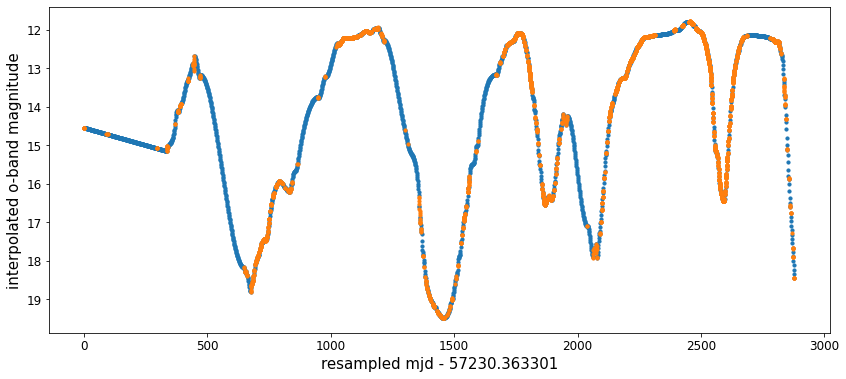

In [36]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,resample_flux,s=10)
plt.scatter(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),np.asarray(iter_savgol_filtered),s=10)
# plt.scatter(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),np.asarray(iter_savgol_filtered),s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
# plt.ylim(20.5,11)
# plt.ylim(14,12)
# plt.xlim(1000,1200)
plt.show()

In [37]:
new_edge_detect = sp.ndimage.convolve(resample_flux, [1.0, 0.0, -1.0])

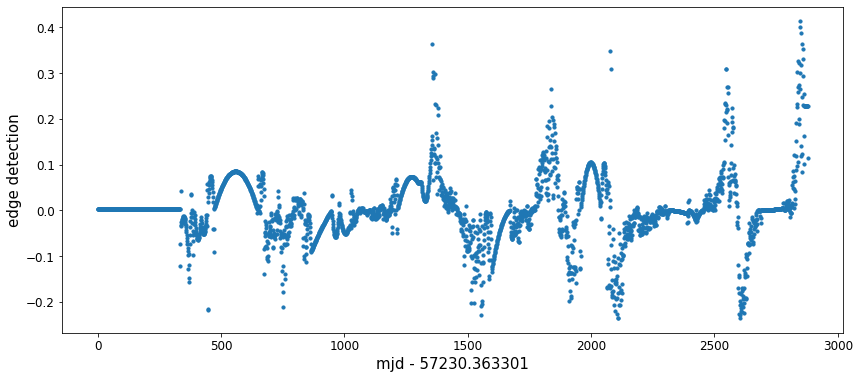

In [38]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,new_edge_detect,s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('edge detection')
# plt.ylim(-1,1)
plt.show()

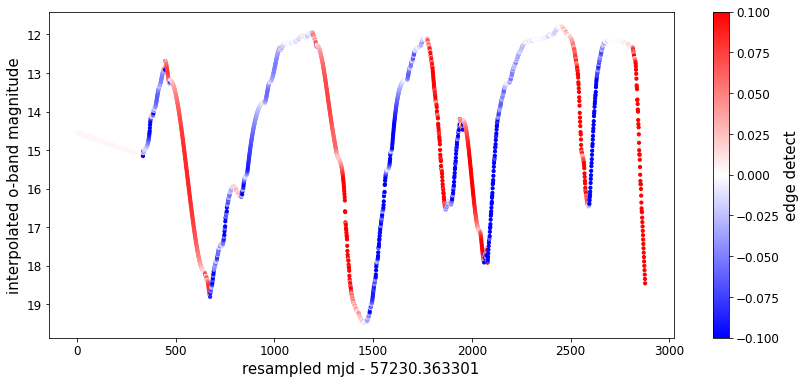

In [39]:
plt.figure(figsize=(14,6))
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.scatter(resample_time,resample_flux,s=10,
            c=new_edge_detect,cmap='bwr')#,alpha=0.2)
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-0.1,0.1)
# lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# plt.clim(-lim,lim)
# plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
plt.show()

# Actually all the GP stuff should go here :)

In [40]:
# kernel = Matern(length_scale=3, nu=3/2) + WhiteKernel(noise_level=1) #+ ConstantKernel()
# # kernel = Matern(length_scale=3, nu=3/2,length_scale_bounds=(150,1e5)) + WhiteKernel(noise_level=1) #+ ConstantKernel()
# # kernel = RBF(length_scale=1,length_scale_bounds=(1e-05, 10)) + WhiteKernel(noise_level=1) #+ ConstantKernel()

In [41]:
# # median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m']

# time = np.asarray(savgol_filtered_oband['mjd']-mjd_scale)
# time = time.reshape(-1,1)

# # the gp assumes the mean value is zero
# # mean_val = np.min(savgol_filtered_oband['m'])
# # norm_val = np.max(savgol_filtered_oband['m']-mean_val)
# mean_val = np.min(iter_savgol_filtered)
# norm_val = np.max(iter_savgol_filtered-mean_val)

In [42]:
# gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
# # gp.fit(time, (savgol_filtered_oband['m']-mean_val)/norm_val)
# gp.fit(time, (iter_savgol_filtered-mean_val)/norm_val)
# # gp.fit(time, savgol_filtered_oband['m'])
# # GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
# #                 kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1),
# #                 n_restarts_optimizer=0, normalize_y=False,
# #                 optimizer='fmin_l_bfgs_b', random_state=None)

In [43]:
# gp.kernel_

### big question: what resolution should I resample to?

Probably once a night is fine, RCBs shouldn't vary much more than that??

In [44]:
# x_pred = np.linspace(0, int(np.max(time))+1, int(np.max(time))+1).reshape(-1,1)
# y_pred, sigma = gp.predict(x_pred, return_std=True)

In [45]:
# plt.figure(figsize=(14,6))

# plt.plot(x_pred,(y_pred*norm_val)+mean_val)
# plt.errorbar(x_pred, (y_pred*norm_val)+mean_val, yerr=sigma*norm_val, capsize=0, color='tab:red',alpha=0.2)
# # plt.plot(x_pred,y_pred)
# # plt.errorbar(x_pred, y_pred, yerr=sigma, capsize=0, color='tab:red',alpha=0.2)

# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,alpha=0.5,color='tab:orange')
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,iter_savgol_filtered,s=10,color='tab:blue',alpha=0.75)

# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('savgol filtered o-band magnitude')
# # plt.xlim(1000,3000)
# plt.show()

In [46]:
# gpsmoothed_time = time
# gpsmoothed_flux, gpsigma = gp.predict(gpsmoothed_time, return_std=True)
# gpsmoothed_flux = (gpsmoothed_flux*norm_val)+mean_val
# gpsigma = gpsigma*norm_val

In [47]:
# # plt.figure(figsize=(14,6))

# plt.plot(x_pred,y_pred)
# plt.errorbar(x_pred, y_pred, yerr=sigma, capsize=0, color='tab:red',alpha=0.2)

# plt.scatter(gpsmoothed_time,gpsmoothed_flux,color='tab:green',zorder=3)

# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10)
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('savgol filtered o-band magnitude')
# # plt.xlim(1000,3000)
# plt.show()

In [48]:
# gp_edge_detect = sp.ndimage.convolve((y_pred*norm_val)+mean_val, [1.0, 0.0, -1.0])

In [49]:
# # np.std()

# plt.figure(figsize=(14,6))
# plt.scatter(x_pred,gp_edge_detect,s=10)
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('edge detection')
# plt.ylim(-0.1,0.1)
# plt.show()

In [50]:
# plt.figure(figsize=(14,6))
# # plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
# plt.scatter(x_pred,(y_pred*norm_val)+mean_val,s=10,
#             c=gp_edge_detect,cmap='bwr')#,alpha=0.2)
# # plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
# plt.gca().invert_yaxis()
# plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
# plt.ylabel('interpolated o-band magnitude')
# plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# plt.clim(-0.1,0.1)
# # lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# # plt.clim(-lim,lim)
# # plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
# plt.show()

In [51]:
# ## interpolate the edge detection to convert back to the original times
# # np.linspace(0, int(np.max(time)), int(np.max(time)))
# gp_edgedetect_interp = sp.interpolate.interp1d(x_pred[:,0],
#                                                  gp_edge_detect,
#                                                  kind='slinear')

# gp_edges = gp_edgedetect_interp(savgol_filtered_oband['mjd']-mjd_scale)

In [52]:
# plt.figure(figsize=(14,6))
# # plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
# plt.scatter(gpsmoothed_time,gpsmoothed_flux,s=10,
#             c=gp_edges,cmap='bwr')#,alpha=0.2)
# # plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
# plt.gca().invert_yaxis()
# plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
# plt.ylabel('interpolated o-band magnitude')
# plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# plt.clim(-0.1,0.1)
# # lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# # plt.clim(-lim,lim)
# # plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
# plt.show()

In [53]:
# plt.figure(figsize=(14,6))

# plt.scatter(gpsmoothed_time,(savgol_filtered_oband['m']-gpsmoothed_flux)+np.min(savgol_filtered_oband['m']),
#             s=10)#,c=gp_edges,cmap='bwr')
# plt.scatter(gpsmoothed_time,savgol_filtered_oband['m'],s=10,
#             c=savgol_filtered_oband['m']-gpsmoothed_flux,cmap='cividis')#,alpha=0.2)

# plt.gca().invert_yaxis()
# plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
# plt.ylabel('interpolated o-band magnitude')
# plt.colorbar(label='diff to gp model')
# plt.clim(-0.25,0.25)
# plt.show()

# Now back to normal

In [54]:
## interpolate the edge detection to convert back to the original times
# edge_detect_interp_func = sp.interpolate.interp1d(resample_time,
#                                                  new_edge_detect,
#                                                  kind='slinear')

# edges_realdata = edge_detect_interp_func(median_filtered_oband['mjd']-mjd_scale)


In [55]:
# plt.figure(figsize=(14,6))
# plt.scatter(median_filtered_oband['mjd']-mjd_scale,edges_realdata,s=10)
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('edge detect back to real data')
# # plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# # plt.clim(-1,1)
# plt.show()

In [56]:
# plt.figure(figsize=(14,6))
# # plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(edges_realdata+3)*4,s=10)
# plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,
#             c=(edges_realdata),cmap='bwr')
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('median filtered o-band magnitude')
# plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# plt.clim(-0.1,0.1)
# # plt.xlim(950,1200)
# # plt.xlim(500,1000)
# # plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
# plt.show()

In [57]:
#### toggle this cell for switching between slinear interpolation and GP interpolation ######

# resample_time = x_pred
# resample_flux = (y_pred*norm_val)+mean_val #y_pred
# new_edge_detect = gp_edge_detect

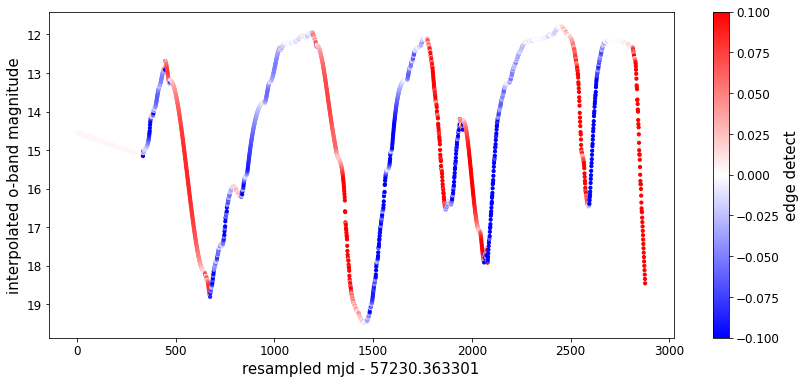

In [58]:
plt.figure(figsize=(14,6))
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.scatter(resample_time,resample_flux,s=10,
            c=new_edge_detect,cmap='bwr')#,alpha=0.2)
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-0.1,0.1)
# lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# plt.clim(-lim,lim)
# plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
plt.show()

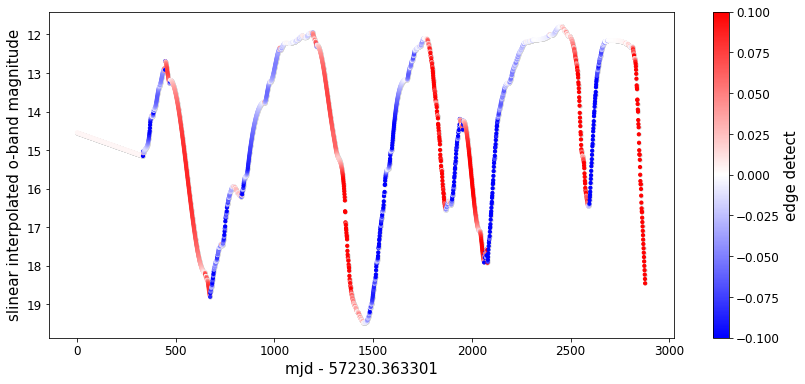

In [59]:
# std_dev = np.std(new_edge_detect)
# # std_dev
# new_mask = np.where(np.abs(new_edge_detect)>(std_dev*0.25),True,False)
new_mask = np.where(np.abs(new_edge_detect)>0,True,False)

plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(gp_edges+3)*4,s=10)
plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
plt.scatter(resample_time[new_mask],resample_flux[new_mask],s=10,
            c=new_edge_detect[new_mask],cmap='bwr')
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,color='lightgrey')
# plt.scatter(savgol_filtered_oband['mjd'][new_mask]-mjd_scale,savgol_filtered_oband['m'][new_mask],s=10,
#             c=(gp_edges[new_mask]),cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('slinear interpolated o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

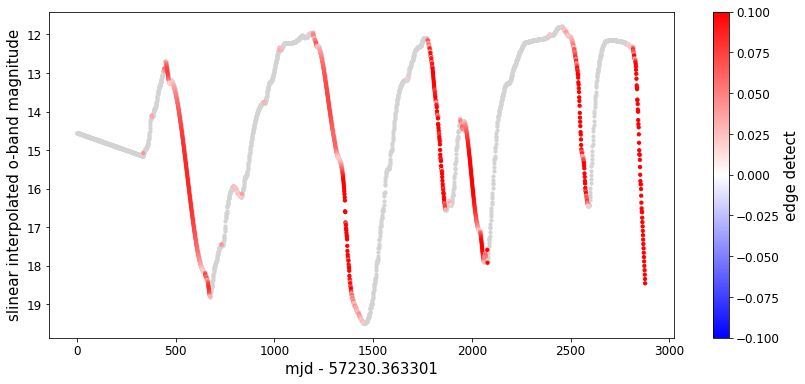

In [60]:
std_dev = np.std(new_edge_detect)
new_mask = np.where(np.abs(new_edge_detect)>(std_dev*0.25),True,False)
downslope_mask = np.where(new_edge_detect>0.0,True,False)
total_mask = new_mask & downslope_mask

plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(gp_edges+3)*4,s=10)
plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
            c=new_edge_detect[total_mask],cmap='bwr')
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,color='lightgrey')
# plt.scatter(savgol_filtered_oband['mjd'][total_mask]-mjd_scale,savgol_filtered_oband['m'][total_mask],s=10,
#             c=(gp_edges[total_mask]),cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('slinear interpolated o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

In [61]:
gradient = np.gradient(resample_flux, resample_time)

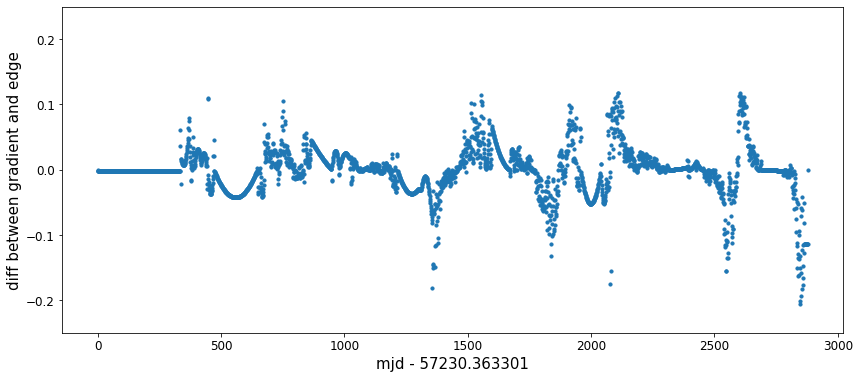

In [62]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,gradient-new_edge_detect,s=10)
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('diff between gradient and edge')
plt.ylim(-0.25,0.25)
plt.show()

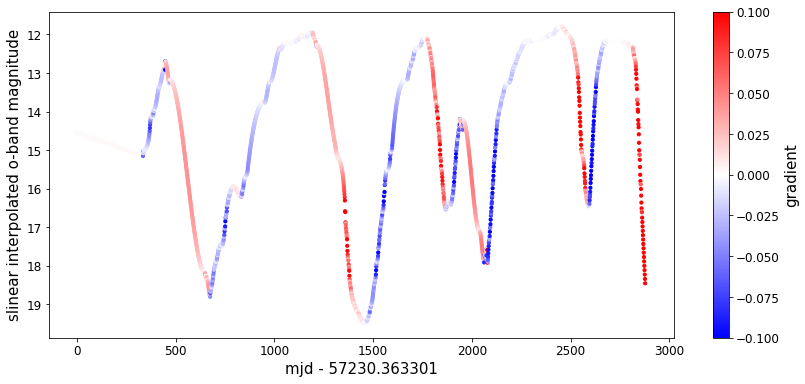

In [63]:
plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(gp_edges+3)*4,s=10)
# plt.scatter(resample_time,gradient,s=10,color='lightgrey')
plt.scatter(resample_time,resample_flux,s=10,
            c=gradient,cmap='bwr')
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,color='lightgrey')
# plt.scatter(savgol_filtered_oband['mjd'][total_mask]-mjd_scale,savgol_filtered_oband['m'][total_mask],s=10,
#             c=(gp_edges[total_mask]),cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('slinear interpolated o-band magnitude')
plt.colorbar(label='gradient')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

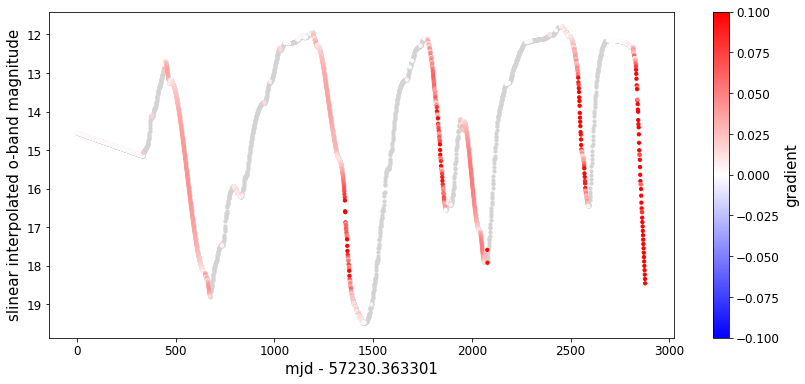

In [64]:
downslope_mask = np.where(gradient>0,True,False)
total_mask = downslope_mask

plt.figure(figsize=(14,6))
plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
plt.scatter(resample_time[downslope_mask],resample_flux[downslope_mask],s=10,
            c=gradient[downslope_mask],cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('slinear interpolated o-band magnitude')
plt.colorbar(label='gradient')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

In [65]:
def find_runs(x):
    x = np.asanyarray(x)
    n = x.shape[0]
    
    # find run starts
    loc_run_start = np.empty(n, dtype=bool)
    loc_run_start[0] = True
    np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
    run_starts = np.nonzero(loc_run_start)[0]

    # find run values
    run_values = x[loc_run_start]

    # find run lengths
    run_lengths = np.diff(np.append(run_starts, n))

    return run_values, run_starts, run_lengths

In [66]:
run_vals, run_start, run_length = find_runs(total_mask)

In [67]:
downward_mask = run_start[np.logical_and(run_vals==True,run_length > 3)]
upward_mask = run_start[np.logical_and(run_vals==False,run_length > 3)]

In [68]:
# resample_time[downward_mask]

In [69]:
# resample_time[run_start]

In [70]:
# resample_flux[run_start]

In [71]:
decline_min_depth = 0.9
decline_onset = []
decline_end = []
decline_depth = []
for i in range(0,len(resample_flux[run_start])):
    if i == 0 and np.abs(resample_flux[0] - resample_flux[run_start[i+1]]) > decline_min_depth:
        ## adding the absolute magnitude should detect beginning declines
        ## NEEDS TO BE TESTED
        decline_onset.append(0)
        print('beginning')
        print('0')
        print(resample_flux[0])
        print(np.abs(resample_flux[0] - resample_flux[run_start[i]]))
        decline_end.append(run_start[i+1])
        decline_depth.append(np.abs(resample_flux[0] - resample_flux[run_start[i+1]]))
    elif i == len(resample_flux[run_start])-1:
        if resample_flux[-1] - resample_flux[run_start[i]] > decline_min_depth:
            decline_onset.append(run_start[i])
            print('end')
            print(run_start[i])
            print(resample_flux[run_start[i]])
            print(resample_flux[-1] - resample_flux[run_start[i]])
            decline_end.append(len(resample_flux)-1)
            decline_depth.append(resample_flux[-1] - resample_flux[run_start[i]])
    elif resample_flux[run_start[i+1]] - resample_flux[run_start[i]] > decline_min_depth:#1:
        decline_onset.append(run_start[i])
        print(run_start[i])
        print(resample_flux[run_start[i]])
        print(resample_flux[run_start[i+1]] - resample_flux[run_start[i]])
        decline_end.append(run_start[i+1])
        decline_depth.append(resample_flux[run_start[i+1]] - resample_flux[run_start[i]])
#     if i == len(resample_flux[run_start]):
#         print('end')

472
13.178960031967256
4.994693798880279
1215
12.268000275096723
6.924119347770256
1764
12.099697504337454
4.443434334746831
1957
14.239485883245262
2.867374392574259
2454
11.792493812905137
4.666681653999968
end
2810
12.313287717234333
6.140541763617049


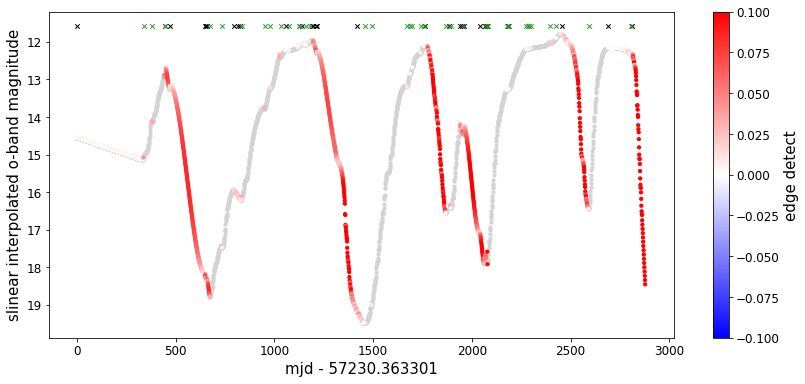

In [72]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
plt.scatter(resample_time[downward_mask],
            np.full(len(resample_time[downward_mask]),np.min(resample_flux))-0.2,
            s=20,marker='x',color='k',zorder=3)
plt.scatter(resample_time[upward_mask],
            np.full(len(resample_time[upward_mask]),np.min(resample_flux))-0.2,
                    s=20,marker='x',color='tab:green',zorder=3)
# plt.scatter(savgol_filtered_oband['mjd'][decline_onset]-mjd_scale,
#             np.full(len(savgol_filtered_oband['mjd'][decline_onset]),np.min(savgol_filtered_oband['m']))-0.2,
#                     s=20,marker='x',color='k',zorder=3)
plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
            c=(new_edge_detect[total_mask]),cmap='bwr')

plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('slinear interpolated o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
plt.show()

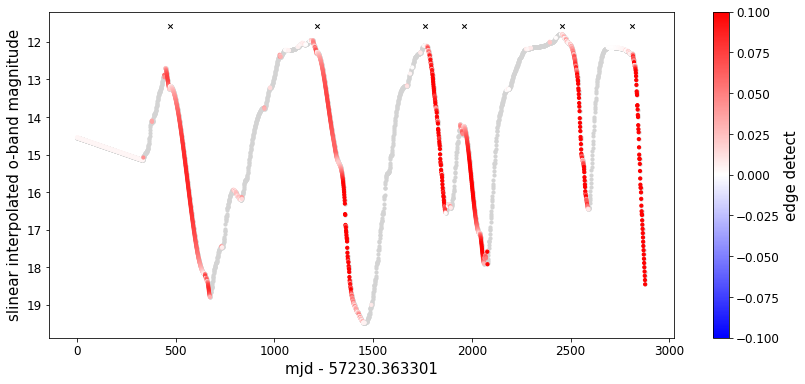

In [73]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
# plt.scatter(resample_time[downward_mask]-mjd_scale,
#             np.full(len(resample_time[downward_mask]),np.min(resample_flux))-0.2
#                     ,s=20,marker='x',color='k',zorder=3)
# plt.scatter(resample_time[upward_mask]-mjd_scale,
#             np.full(len(resample_time[upward_mask]),np.min(resample_flux))-0.2
#                     ,s=20,marker='x',color='tab:green',zorder=3)
plt.scatter(resample_time[decline_onset],
            np.full(len(resample_time[decline_onset]),np.min(resample_flux))-0.2,
                    s=20,marker='x',color='k',zorder=3)
plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
            c=(new_edge_detect[total_mask]),cmap='bwr')

plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('slinear interpolated o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
# plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight')
plt.show()

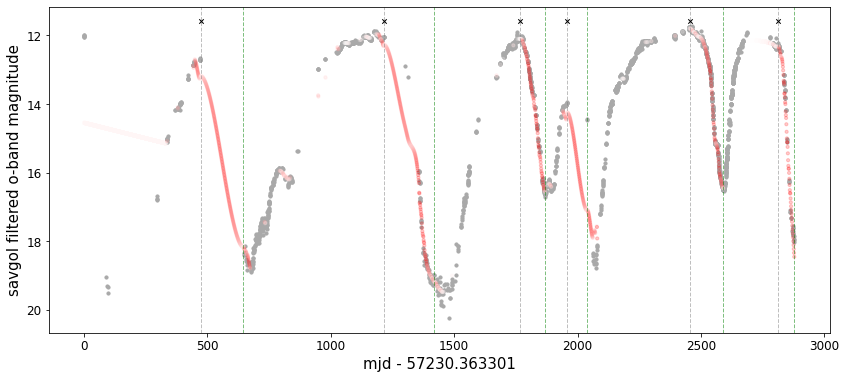

In [74]:
plt.figure(figsize=(14,6))
plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],
            s=10,color='darkgrey')
plt.scatter(resample_time[decline_onset],
            np.full(len(resample_time[decline_onset]),np.min(resample_flux))-0.2,
                    s=20,marker='x',color='k',zorder=3)
plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
            c=(new_edge_detect[total_mask]),cmap='bwr',alpha=0.2)

for i in range(0,len(resample_time[decline_onset])):
    onset_time = resample_time[decline_onset][i]
    diff_arr = np.abs((savgol_filtered_oband['mjd'][saturation_mask]-mjd_scale)-onset_time)
    if np.min(diff_arr) > 5:
        if decline_depth[i] > 12-np.min(savgol_filtered_oband['m']):
            plt.axvline(onset_time,color='red',linestyle='--')
            plt.axvline(decline_end[i],color='green',linestyle='--',alpha=0.5)
        else:
            pass
#             plt.axvline(onset_time,color='red',linestyle='--')
    else:
        plt.axvline(onset_time,color='grey',linestyle='--',alpha=0.5)
        plt.axvline(decline_end[i],color='green',linestyle='--',alpha=0.5)

plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
# plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight')
plt.show()

# if you wanted to resample back to the original dataset first

In [75]:
# std_dev = np.std(gp_edges)
# # std_dev
# new_mask = np.where(np.abs(gp_edges)>(std_dev*0.25),True,False)

# plt.figure(figsize=(14,6))
# # plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(gp_edges+3)*4,s=10)
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,color='lightgrey')
# plt.scatter(savgol_filtered_oband['mjd'][new_mask]-mjd_scale,savgol_filtered_oband['m'][new_mask],s=10,
#             c=(gp_edges[new_mask]),cmap='bwr')
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='edge detect')
# plt.clim(-0.1,0.1)
# # plt.xlim(950,1200)
# # plt.xlim(500,1000)
# plt.show()

In [76]:
# std_dev = np.std(gp_edges)
# new_mask = np.where(np.abs(gp_edges)>(std_dev*0.25),True,False)
# downslope_mask = np.where(gp_edges>0.0,True,False)
# total_mask = new_mask & downslope_mask

# plt.figure(figsize=(14,6))
# # plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(gp_edges+3)*4,s=10)
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,color='lightgrey')
# plt.scatter(savgol_filtered_oband['mjd'][total_mask]-mjd_scale,savgol_filtered_oband['m'][total_mask],s=10,
#             c=(gp_edges[total_mask]),cmap='bwr')
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='edge detect')
# plt.clim(-0.1,0.1)
# # plt.xlim(950,1200)
# # plt.xlim(500,1000)
# plt.show()

In [77]:
# print(savgol_filtered_oband['mjd'][total_mask]-mjd_scale)

In [78]:
# def find_runs(x):
#     x = np.asanyarray(x)
#     n = x.shape[0]
    
#     # find run starts
#     loc_run_start = np.empty(n, dtype=bool)
#     loc_run_start[0] = True
#     np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
#     run_starts = np.nonzero(loc_run_start)[0]

#     # find run values
#     run_values = x[loc_run_start]

#     # find run lengths
#     run_lengths = np.diff(np.append(run_starts, n))

#     return run_values, run_starts, run_lengths

In [79]:
# run_vals, run_start, run_length = find_runs(total_mask)

In [80]:
# downward_mask = run_start[np.logical_and(run_vals==True,run_length > 3)]
# upward_mask = run_start[np.logical_and(run_vals==False,run_length > 3)]

In [81]:
# savgol_filtered_oband['mjd'][downward_mask]-mjd_scale

In [82]:
# savgol_filtered_oband['mjd'][run_start]

In [83]:
# savgol_filtered_oband['m'][run_start]

In [84]:
# decline_onset = []
# decline_end = []
# for i in range(0,len(savgol_filtered_oband['m'][run_start])):
#     if i == 0 and np.abs(savgol_filtered_oband['m'].iloc[0] - savgol_filtered_oband['m'][run_start[i+1]]) > 0.8:
#         ## adding the absolute magnitude should detect beginning declines
#         ## NEEDS TO BE TESTED
#         decline_onset.append(0)
#         print('beginning')
#         print('0')
#         print(savgol_filtered_oband['mjd'][0])
#         print(np.abs(savgol_filtered_oband['m'].iloc[0] - savgol_filtered_oband['m'][run_start[i]]))
#     elif i == len(savgol_filtered_oband['m'][run_start])-1:
#         if savgol_filtered_oband['m'].iloc[-1] - savgol_filtered_oband['m'][run_start[i]] > 0.8:
#             decline_onset.append(run_start[i])
#             print('end')
#             print(run_start[i])
#             print(savgol_filtered_oband['mjd'][run_start[i]])
#             print(savgol_filtered_oband['m'].iloc[-1] - savgol_filtered_oband['m'][run_start[i]])
#     elif savgol_filtered_oband['m'][run_start[i+1]] - savgol_filtered_oband['m'][run_start[i]] > 0.8:#1:
#         decline_onset.append(run_start[i])
#         print(run_start[i])
#         print(savgol_filtered_oband['mjd'][run_start[i]])
#         print(savgol_filtered_oband['m'][run_start[i+1]] - savgol_filtered_oband['m'][run_start[i]])
# #     if i == len(savgol_filtered_oband['m'][run_start]):
# #         print('end')

In [85]:
# plt.figure(figsize=(14,6))
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,color='lightgrey')
# plt.scatter(savgol_filtered_oband['mjd'][downward_mask]-mjd_scale,
#             np.full(len(savgol_filtered_oband['mjd'][downward_mask]),np.min(savgol_filtered_oband['m']))-0.2
#                     ,s=20,marker='x',color='k',zorder=3)
# plt.scatter(savgol_filtered_oband['mjd'][upward_mask]-mjd_scale,
#             np.full(len(savgol_filtered_oband['mjd'][upward_mask]),np.min(savgol_filtered_oband['m']))-0.2
#                     ,s=20,marker='x',color='tab:green',zorder=3)
# # plt.scatter(savgol_filtered_oband['mjd'][decline_onset]-mjd_scale,
# #             np.full(len(savgol_filtered_oband['mjd'][decline_onset]),np.min(savgol_filtered_oband['m']))-0.2,
# #                     s=20,marker='x',color='k',zorder=3)
# plt.scatter(savgol_filtered_oband['mjd'][total_mask]-mjd_scale,savgol_filtered_oband['m'][total_mask],s=10,
#             c=(gp_edges[total_mask]),cmap='bwr')

# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='edge detect')
# plt.clim(-0.1,0.1)
# plt.show()

In [86]:
# plt.figure(figsize=(14,6))
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,color='lightgrey')
# # plt.scatter(savgol_filtered_oband['mjd'][downward_mask]-mjd_scale,
# #             np.full(len(savgol_filtered_oband['mjd'][downward_mask]),np.min(savgol_filtered_oband['m']))-0.2
# #                     ,s=20,marker='x',color='k',zorder=3)
# # plt.scatter(savgol_filtered_oband['mjd'][upward_mask]-mjd_scale,
# #             np.full(len(savgol_filtered_oband['mjd'][upward_mask]),np.min(savgol_filtered_oband['m']))-0.2
# #                     ,s=20,marker='x',color='tab:green',zorder=3)
# plt.scatter(savgol_filtered_oband['mjd'][decline_onset]-mjd_scale,
#             np.full(len(savgol_filtered_oband['mjd'][decline_onset]),np.min(savgol_filtered_oband['m']))-0.2,
#                     s=20,marker='x',color='k',zorder=3)
# plt.scatter(savgol_filtered_oband['mjd'][total_mask]-mjd_scale,savgol_filtered_oband['m'][total_mask],s=10,
#             c=(gp_edges[total_mask]),cmap='bwr')

# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='edge detect')
# plt.clim(-0.1,0.1)
# # plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight')
# plt.show()